In [1]:
import os
import pickle as pkl
import sys

import pandas as pd
import networkx as nx
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
DATADIR = os.path.join(os.getcwd(), "data")
EMBEDDING_DIR = os.path.join(DATADIR, "embeddings")
TWITTER_DIR = os.path.join(DATADIR, "twitter")

In [3]:
def load_twitter_data(data_path, use_feats):
    
    with open(os.path.join(data_path, "all_twitter_ids.csv"), 'r') as f:
            all_twitter_ids = f.readlines()
    all_twitter_ids = all_twitter_ids[1:]
    all_twitter_ids = [x.rstrip('\n') for x in all_twitter_ids]
    all_twitter_ids = np.array(all_twitter_ids)
    
    idx_to_object = dict(enumerate(all_twitter_ids.flatten()))
    object_to_idx= {v: k for k, v in idx_to_object.items()}   
    
    adj = np.zeros((all_twitter_ids.shape[0], all_twitter_ids.shape[0]))
    
    #names = ['favorite_list', 'friend_list', 'mention_list', 'reply_list', 'retweet_list']
    names = ['friend_list']
    idx_counter = 0
    edges = []
    for name in names:
        with open(os.path.join(data_path, "{}.csv".format(name)), 'r') as f:
            all_edges = f.readlines()
        all_edges = all_edges[1:]
        for line in all_edges:
            n1, n2, _ = line.rstrip().split('\t')
            i = object_to_idx[n1]
            j = object_to_idx[n2]
            edges.append((i, j))            
    
    print(adj.shape)
    for i, j in edges:
        adj[i, j] = 1.  
        #adj[j, i] = 1. # comment this line for directed adjacency matrix
        
    data = pd.read_csv(os.path.join(data_path, "dict.csv"), sep='\t', dtype={"twitter_id":'str'})
    #data.drop(data[data['party'] == 'I'].index, inplace=True)
    data.replace({'party': {'D': 0, 'I': 0, 'R': 1}}, inplace=True)
    #data = data[['twitter_id', 'party']]#.values
    
    labels = np.asarray([])
    for key in object_to_idx:
    	labels = np.concatenate((labels, data[data['twitter_id']==key]['party'].to_numpy()))
    	#labels.append(data[data['twitter_id']==key]['party'].value)
    
    #labels = data[:, 1]
        
    
    if use_feats == 1:
        user_features = np.load(os.path.join(data_path, 'features.npz'))
        features = np.concatenate(
            (user_features['description'], user_features['status']),
            axis=1)
    elif use_feats == 2:
        features = np.load(os.path.join(data_path, 'features.npz'))['description']
    elif use_feats == 3:
        features = np.load(os.path.join(data_path, 'features.npz'))['status']
    else:
        features = sp.eye(adj.shape[0])
    return sp.csr_matrix(adj), features, labels, idx_to_object, object_to_idx

adj, features, labels, idx_to_object, object_to_idx = load_twitter_data(TWITTER_DIR, 0)

(583, 583)


In [4]:
embedding_file_name = "embeddings.npy"

embedding = np.load(os.path.join(EMBEDDING_DIR, embedding_file_name))

In [5]:
edge_df= pd.read_csv(os.path.join(TWITTER_DIR, "friend_list.csv"), sep='\t', dtype='str')
edge_df["count"] = edge_df["count"].astype(int)
follower_counts = edge_df.groupby("followee")["count"].sum()
most_important = follower_counts[(follower_counts > 215) | (follower_counts < 2)]

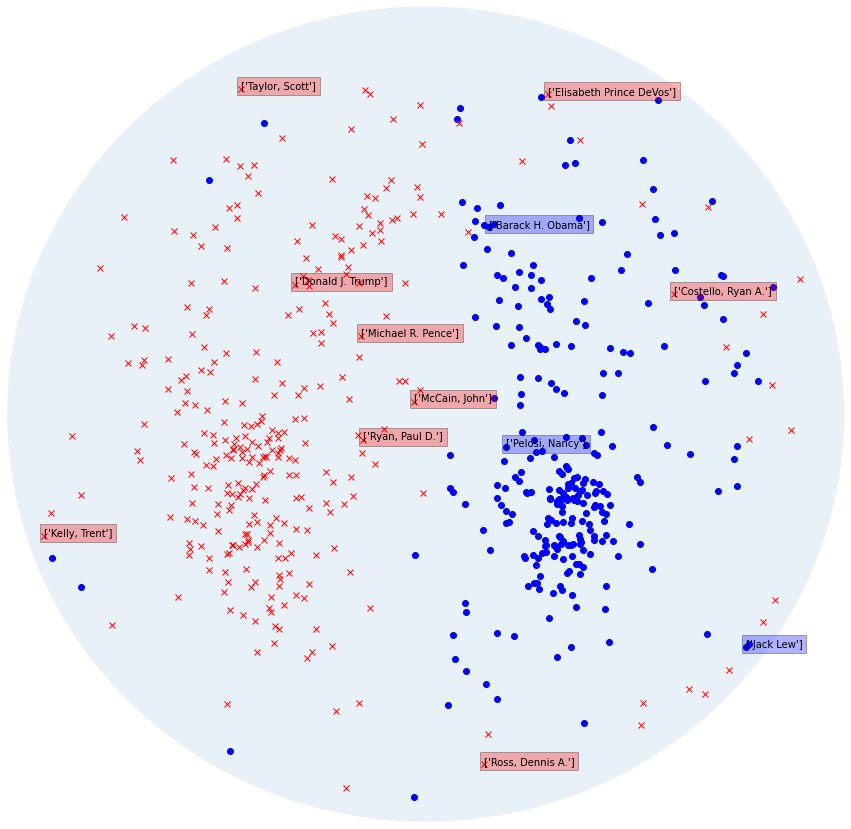

In [6]:
plt.rcParams['figure.figsize'] = (15, 15)

figure, axes = plt.subplots() 
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')

circle = plt.Circle(( 0 , 0 ), 1 , alpha=0.1) 
axes.add_patch(circle)

for x in range(embedding.shape[0]):
    if labels[x] == 0:
      marker = 'bo'
    elif labels[x] == 1:
      marker = 'rx'
    axes.plot(embedding[x,0], embedding[x,1], marker)

dict_df = pd.read_csv(os.path.join(TWITTER_DIR, "dict.csv"), sep='\t',   dtype={"twitter_id":'str'})
dict_df.replace({'party': {'D': 0, 'I': 0, 'R': 1}}, inplace=True)
for person in most_important.index:
  person_entry = dict_df[dict_df["twitter_id"]==person]
  name = person_entry['name'].values
  party = person_entry['party'].values
  node_id = object_to_idx[person]
  color = "red" if party else "blue"
  plt.annotate(name, (embedding[node_id,0], embedding[node_id,1]),
                 bbox={"fc":color, "alpha":0.3})
 
 
plt.show()